# [IAPR 2018:][iapr2018] Lab 2 ‒  Object description

**Author:** Christine Roth  
**Due date:** 04.05.2018

[iapr2018]: https://github.com/LTS5/iapr-2018

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

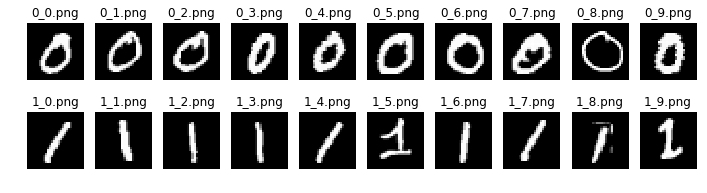

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2Fourier descriptors
Before being able to compute the Fourier descriptors, a contour needs to be identified. For this [Active contours](http://scikit-image.org/docs/dev/auto_examples/edges/plot_active_contours.html) is used. To get a satisfactory contour, meaning a contour that sits nicely around the object, first the number is reduced to its [skeletton](http://scikit-image.org/docs/dev/auto_examples/edges/plot_skeleton.html). However, the method works better when the edges are slightly smoothed, which is why we apply a gaussian filter before starting to shrink the contour. The function has the following parameters:

    alpha: The higher the faster the snake shrinks
    beta: Smoothness of the contour, high values have a strong smoothing effect
    w_line: controls attraction to brightness (>0 attraction <0 rejection)
    w_edge: attraction to edges 
    ...

There are several configurations that give nice results, some allow to distinguish better, others worse. What is important to acknowledge is that for a successful classification of the object, the contour doesn't necessarily "sit" perfectly on the object. it is much more important that it's resulting contour resembles the contour of the other objects that are part of the same subset.

Once the contour is known, the [Fourier Transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html#scipy.fftpack.fft) can be calculated to determine the Fourier descriptors.

For zeros and one, both 0 vs 1st and 1st vs 2nd give nice discrete distributions.

These results are rotation invariant as the absolute value of the coefficient is evaluated, thus the phase which indicates the rotation is not taken into consideration. Translation does affect the first coefficient, but as the evaluated areas are compared in the same size and in the same contouring box, translation has only minimal effect on the result. This suggest that data that is to be analysed needs to be pre-processed before the comparison is made. Another possibility is to compare the ratio of Fourier coefficient, to eliminate scaling effects.


ACTIVE CONTOUR


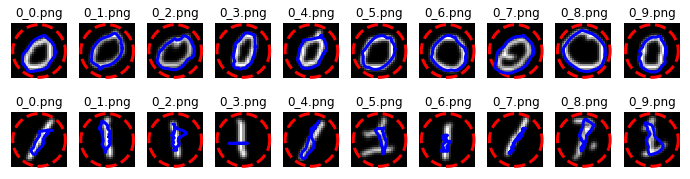

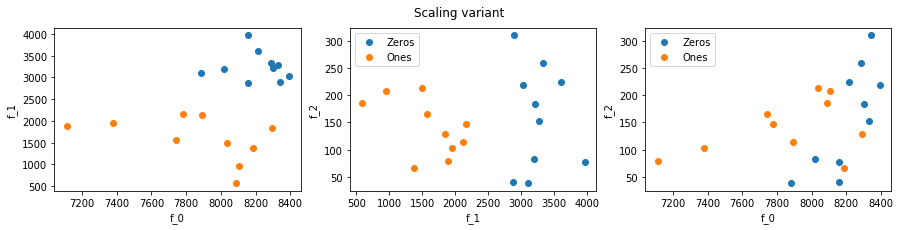

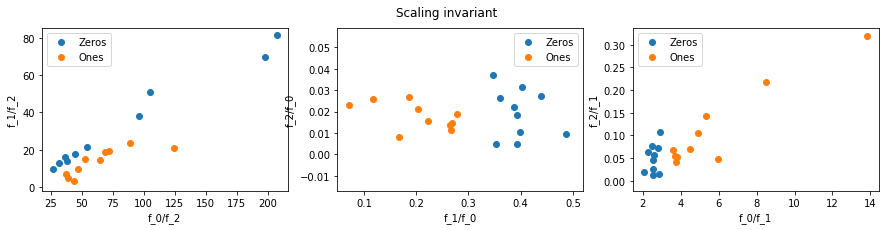

In [3]:
import numpy as np
s = np.linspace(0, 2*np.pi, 400)
size=zeros_im.shape[1]//2
x = size+(size-1)*np.cos(s)
y = size+(size-1)*np.sin(s)
init = np.array([x, y]).T
zeros_bin=zeros_im>0.9;
ones_bin=ones_im>0.9;
from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.morphology import skeletonize
print('ACTIVE CONTOUR')
def active(im):
       from skimage.morphology import skeletonize,binary_erosion
       from scipy.fftpack import fft
       sk=skeletonize(im)
       sk=gaussian(sk,sigma=1)
       #snake = active_contour(sk,init, alpha=1, beta=1e4,w_line=0,w_edge=1)
       #best snake = active_contour(sk,init, alpha=1, beta=100,w_line=-0.2,w_edge=0.2) #sigma=1
       #snake = active_contour(sk,init, alpha=1, beta=10,w_line=-0.2,w_edge=0.2)
        ################################## ok
       #snake = active_contour(sk,init, alpha=1, beta=100,w_line=-0.2,w_edge=0.2) #sigma=1
        ###############################
       #snake = active_contour(sk,init, alpha=1, beta=100,w_line=-1)
        ################################# well
       snake = active_contour(sk,init, alpha=1, beta=1e4,w_line=-0.3) #sigma=1
        ###################################
       FT=fft(snake[:,0]+1j*snake[:,1])
       return im,sk,snake,FT

FT0=[];
FT1=[];
fig2, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_bin, zeros_names):
       ac,sk,snake,FT=active(im)
       FT0.append(np.abs([FT[0],FT[1],FT[2]]))
       ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
       ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
       ax.set_xticks([]), ax.set_yticks([])
       ax.axis([0, im.shape[1], im.shape[0], 0])
       ax.imshow(sk, cmap='gray')
       ax.axis('off')
       ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_bin, zeros_names):
       ac,sk,snake,FT=active(im)
       FT1.append(np.abs([FT[0],FT[1],FT[2]]))
       ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
       ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
       ax.set_xticks([]), ax.set_yticks([])
       ax.axis([0, im.shape[1], im.shape[0], 0])
       ax.imshow(sk, cmap='gray')
       ax.axis('off')
       ax.set_title(nm)
#%matplotlib auto
fig,ax=plt.subplots(1,3,figsize=(5*3,3*1))
fig.suptitle('Scaling variant')
FT0=np.array(FT0)
FT1=np.array(FT1)
ax[0].scatter(FT0.T[0,:],FT0.T[1,:],label='Zeros')
ax[0].scatter(FT1.T[0,:],FT1.T[1,:],label='Ones')
ax[0].set(xlabel='f_0',ylabel='f_1')
ax[1].scatter(FT0.T[1,:],FT0.T[2,:],label='Zeros')
ax[1].scatter(FT1.T[1,:],FT1.T[2,:],label='Ones')
ax[1].legend()
ax[1].set(xlabel='f_1',ylabel='f_2')
ax[2].scatter(FT0.T[0,:],FT0.T[2,:],label='Zeros')
ax[2].scatter(FT1.T[0,:],FT1.T[2,:],label='Ones')
ax[2].legend()
ax[2].set(xlabel='f_0',ylabel='f_2')
plt.show()

fig,ax=plt.subplots(1,3,figsize=(5*3,3*1))
fig.suptitle('Scaling invariant')
FT0=np.array(FT0)
FT1=np.array(FT1)
ax[0].scatter(np.divide(FT0.T[0,:],FT0.T[2,:]),np.divide(FT0.T[1,:],FT0.T[2,:]),label='Zeros')
ax[0].scatter(np.divide(FT1.T[0,:],FT1.T[2,:]),np.divide(FT1.T[1,:],FT1.T[2,:]),label='Ones')
ax[0].set(xlabel='f_0/f_2',ylabel='f_1/f_2')
ax[0].legend()
ax[1].scatter(np.divide(FT0.T[1,:],FT0.T[0,:]),np.divide(FT0.T[2,:],FT0.T[0,:]),label='Zeros')
ax[1].scatter(np.divide(FT1.T[1,:],FT1.T[0,:]),np.divide(FT1.T[2,:],FT1.T[0,:]),label='Ones')
ax[1].legend()
ax[1].set(xlabel='f_1/f_0',ylabel='f_2/f_0')
ax[2].scatter(np.divide(FT0.T[0,:],FT0.T[1,:]),np.divide(FT0.T[2,:],FT0.T[1,:]),label='Zeros')
ax[2].scatter(np.divide(FT1.T[0,:],FT1.T[1,:]),np.divide(FT1.T[2,:],FT1.T[1,:]),label='Ones')
ax[2].legend()
ax[2].set(xlabel='f_0/f_1',ylabel='f_2/f_1')
plt.show()

It shows clearly that the normalized coefficients allow for a more compact distribution than the unnormalized ones. Thus even with images of similar size it seems useful to use scaling invariant features.

### 1.3 Additional method(s)
#### Marching squares algorithm
Another option to determine the contour is [finding contours](http://scikit-image.org/docs/dev/auto_examples/edges/plot_contours.html) this method uses the [marching squares algorithm](http://users.polytech.unice.fr/~lingrand/MarchingCubes/algo.html) to determine the contour. The marching squares tries to draw lines between interpolated values along the edges of a square, considering given weights of the corners and a reference value. Each point of a grid has a weight. By interpolating between the weights of two points, an isocurve (isosurface in 3D) can be determined. at a given reference value. By connecting the points on the interpolated curve that equal a reference value, a contour is obtained.

To improve the result, the image is binarily opened slightly to remove sharp edge effects like an improper ending of a pen.

Here as well scaling invariant and normalized Fourier descriptors are used to compute the distribution of the objects. For this method the scaling invariant descriptors do compute more distributed flocks of points, but it is in both cases easily possible to find a pair of descriptors that allow distinguish between zeros and ones. The scaling doesn't necessarily improve the classification.


CONTOUR_FINDING


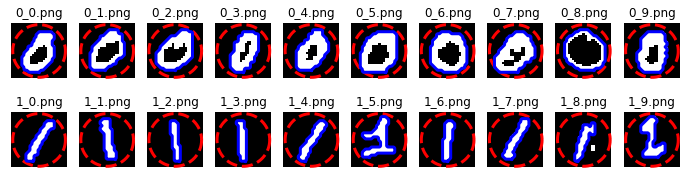

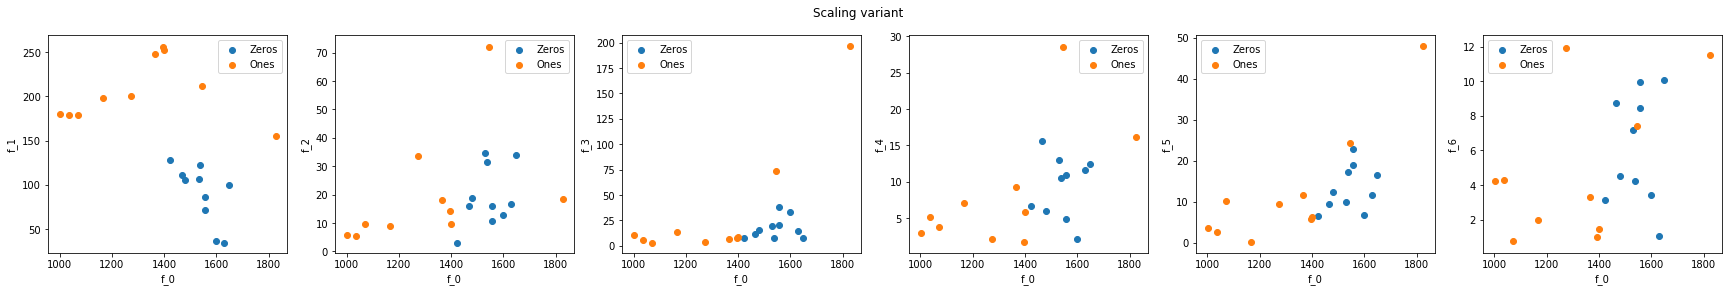

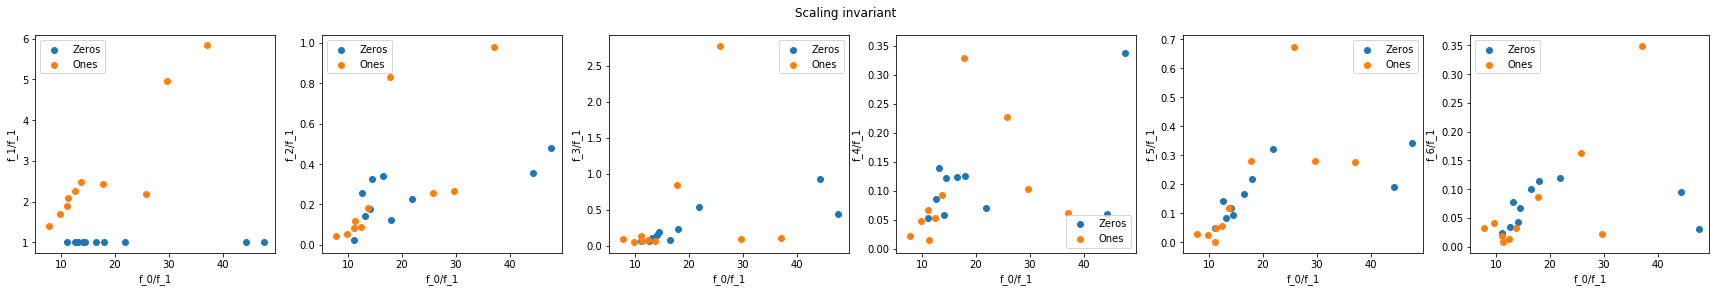

In [4]:
def contour(im):
       from skimage.morphology import skeletonize,binary_opening,binary_closing,binary_dilation,binary_erosion
       from skimage.measure import find_contours
       from scipy.fftpack import fft
       im2=binary_opening(im,np.ones((2,2)))
       snake = find_contours(im2,0.5)[0]
       FT=fft(snake[:,0]+1j*snake[:,1])
       return im2,sk,snake,FT
print('CONTOUR_FINDING')
FT0=[];
FT1=[];
fig2, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
       ac,sk,snake,FT=contour(im)
       FT0.append(np.abs(FT))
       ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
       ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
       ax.set_xticks([]), ax.set_yticks([])
       ax.axis([0, im.shape[1], im.shape[0], 0])
       ax.imshow(ac, cmap='gray')
       ax.axis('off')
       ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
       ac,sk,snake,FT=contour(im)
       FT1.append(np.abs(FT))
       ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
       ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
       ax.set_xticks([]), ax.set_yticks([])
       ax.axis([0, im.shape[1], im.shape[0], 0])
       ax.imshow(ac, cmap='gray')
       ax.axis('off')
       ax.set_title(nm)
#%matplotlib auto
fig,ax=plt.subplots(1,6,figsize=(5*6,4*1))
fig.suptitle('Scaling variant')
FT0=np.array(FT0)
FT1=np.array(FT1)
for j in range(6):
    ax[j].scatter([FT0[i][0] for i in range(FT0.size)],[FT0[i][j+1] for i in range(FT0.size)],label='Zeros')
    ax[j].scatter([FT1[i][0] for i in range(FT1.size)],[FT1[i][j+1] for i in range(FT1.size)],label='Ones')
    ax[j].legend()
    ax[j].set(xlabel='f_%s'%0,ylabel='f_%s'%(j+1))

    
fig,ax=plt.subplots(1,6,figsize=(5*6,4*1))
fig.suptitle('Scaling invariant')
FT0=np.array(FT0)
FT1=np.array(FT1)
for j in range(6):
    ax[j].scatter([FT0[i][0]/FT0[i][1] for i in range(FT0.size)],[FT0[i][j+1]/FT0[i][1] for i in range(FT0.size)],label='Zeros')
    ax[j].scatter([FT1[i][0]/FT0[i][1] for i in range(FT1.size)],[FT1[i][j+1]/FT0[i][1] for i in range(FT1.size)],label='Ones')
    ax[j].legend()
    ax[j].set(xlabel='f_%s/f_1'%0,ylabel='f_%s/f_1'%(j+1))


## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 1.1 Data visualization

In [5]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)
# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)
#  Load two
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load three
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

### 1.2 Fourier descriptors
The twos and threes are not very well detected using the active contour model described above, therefore we used the marching squares method for the contour identification. As is visible in the graphs below, the subsets don't scatter in well-defined regions if only two descriptors are used. By identifying a descriptor that allows to separate twos and threes in a three-dimensional space, the numbers can be categorized.

For the 3D plot f0,f1 and f5 are used, as f5 seems to be best to separate twos from threes. However already with 4 objects, the differentiation is not very easy so advanced techniques need to be applied to teach the code how it needs to interpret the obtained categorization.


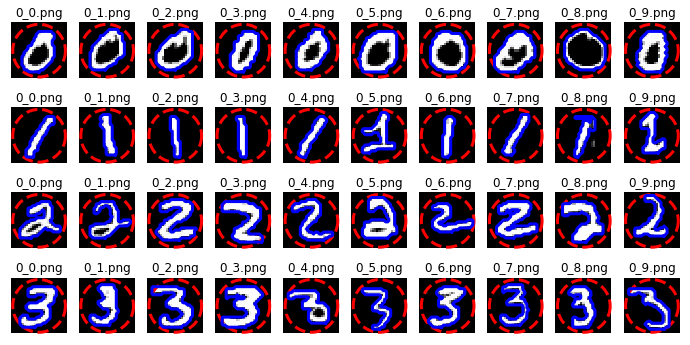

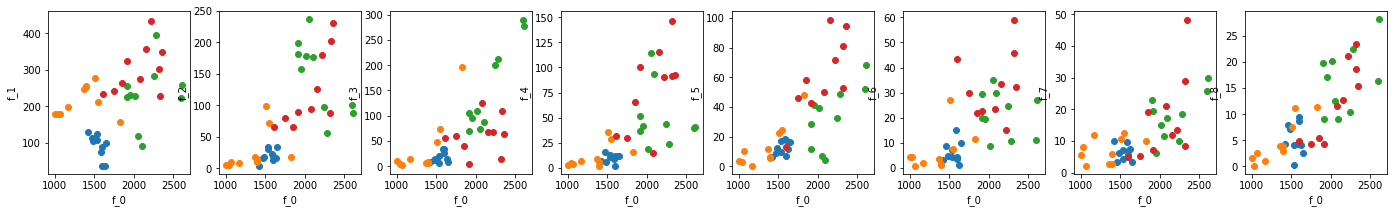

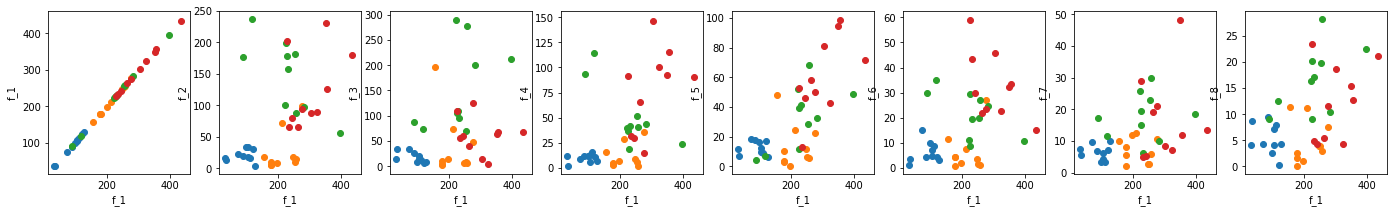

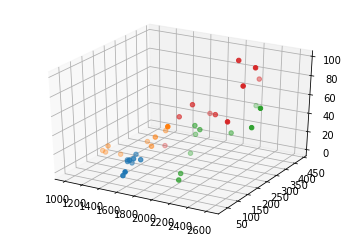

In [6]:
%matplotlib inline
s = np.linspace(0, 2*np.pi, 400)
size=zeros_im.shape[1]//2
x = size+(size-1)*np.cos(s)
y = size+(size-1)*np.sin(s)
init = np.array([x, y]).T
def contour(im):
       from skimage.morphology import skeletonize,binary_opening,binary_closing,binary_dilation,binary_erosion
       from skimage.measure import find_contours
       from scipy.fftpack import fft
       im2=binary_dilation(im,np.ones((1,1)))
       snake = find_contours(im2,0.5)[0]
       FT=fft(snake[:,0]+1j*snake[:,1])
       return im2,sk,snake,FT
FT0=[];
FT1=[];
FT2=[];
FT3=[];
zeros_fim=skimage.img_as_float(zeros_im)
ones_fim=skimage.img_as_float(ones_im)
twos_fim=skimage.img_as_float(twos_im)
threes_fim=skimage.img_as_float(threes_im)
fig2, axes = plt.subplots(4, len(zeros_im), figsize=(12, 3*2))
for ax, im, nm in zip(axes[0], zeros_fim, zeros_names):
       ac,sk,snake,FT=contour(im)
       FT0.append(np.abs(FT))
       ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
       ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
       ax.set_xticks([]), ax.set_yticks([])
       ax.axis([0, im.shape[1], im.shape[0], 0])
       ax.imshow(im, cmap='gray')
       ax.axis('off')
       ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_fim, zeros_names):
       ac,sk,snake,FT=contour(im)
       FT1.append(np.abs(FT))
       ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
       ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
       ax.set_xticks([]), ax.set_yticks([])
       ax.axis([0, im.shape[1], im.shape[0], 0])
       ax.imshow(im, cmap='gray')
       ax.axis('off')
       ax.set_title(nm)
for ax, im, nm in zip(axes[2], twos_fim, zeros_names):
       ac,sk,snake,FT=contour(im)
       FT2.append(np.abs(FT))
       ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
       ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
       ax.set_xticks([]), ax.set_yticks([])
       ax.axis([0, im.shape[1], im.shape[0], 0])
       ax.imshow(im, cmap='gray')
       ax.axis('off')
       ax.set_title(nm)
for ax, im, nm in zip(axes[3], threes_fim, zeros_names):
       ac,sk,snake,FT=contour(im)
       FT3.append(np.abs(FT))
       ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
       ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
       ax.set_xticks([]), ax.set_yticks([])
       ax.axis([0, im.shape[1], im.shape[0], 0])
       ax.imshow(im, cmap='gray')
       ax.axis('off')
       ax.set_title(nm)
FT0=np.array(FT0)
FT1=np.array(FT1)
FT2=np.array(FT2)
FT3=np.array(FT3)
fig,ax=plt.subplots(1,8,figsize=(8*3,1*3))
for j in range(8):
       ax[j].scatter([FT0[i][0] for i in range(FT0.size)],[FT0[i][j+1] for i in range(FT0.size)])
       ax[j].scatter([FT1[i][0] for i in range(FT1.size)],[FT1[i][j+1] for i in range(FT1.size)])
       ax[j].scatter([FT2[i][0] for i in range(FT2.size)],[FT2[i][j+1] for i in range(FT2.size)])
       ax[j].scatter([FT3[i][0] for i in range(FT3.size)],[FT3[i][j+1] for i in range(FT3.size)])
       ax[j].set_xlabel("f_0")
       ax[j].set_ylabel("f_%s"%str(j+1))
plt.show()
fig,ax=plt.subplots(1,8,figsize=(8*3,1*3))
for j in range(8):
       ax[j].scatter([FT0[i][1] for i in range(FT0.size)],[FT0[i][j+1] for i in range(FT0.size)])
       ax[j].scatter([FT1[i][1] for i in range(FT1.size)],[FT1[i][j+1] for i in range(FT1.size)])
       ax[j].scatter([FT2[i][1] for i in range(FT2.size)],[FT2[i][j+1] for i in range(FT2.size)])
       ax[j].scatter([FT3[i][1] for i in range(FT3.size)],[FT3[i][j+1] for i in range(FT3.size)])
       ax[j].set_xlabel("f_1")
       ax[j].set_ylabel("f_%s"%str(j+1))
plt.show()
#%matplotlib auto
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([FT0[i][0] for i in range(FT0.size)],[FT0[i][1] for i in range(FT0.size)],[FT0[i][5] for i in range(FT0.size)])
ax.scatter([FT1[i][0] for i in range(FT0.size)],[FT1[i][1] for i in range(FT0.size)],[FT1[i][5] for i in range(FT0.size)])
ax.scatter([FT2[i][0] for i in range(FT0.size)],[FT2[i][1] for i in range(FT0.size)],[FT2[i][5] for i in range(FT0.size)])
ax.scatter([FT3[i][0] for i in range(FT0.size)],[FT3[i][1] for i in range(FT0.size)],[FT3[i][5] for i in range(FT0.size)])
plt.show()

### 1.3 Additional method(s)
#### Region Based description
It is not only possible to describe objects using their contours, but they can also be described using different properties of their regions. Such as perimeter, area, moments, eigenvalues, ...

Here we test how these methods work on our dataset. There exist many other ways of describing objects based on region this is mere a selection.


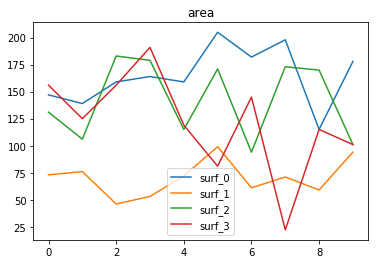

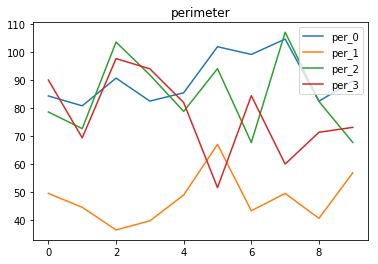

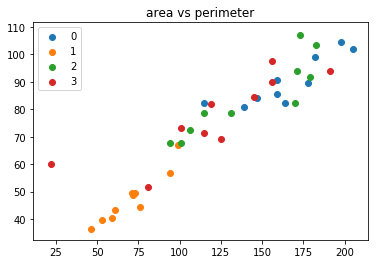

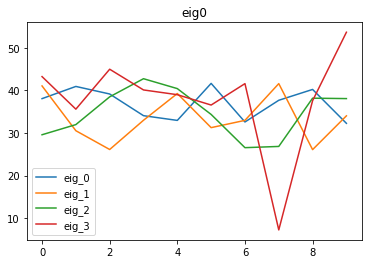

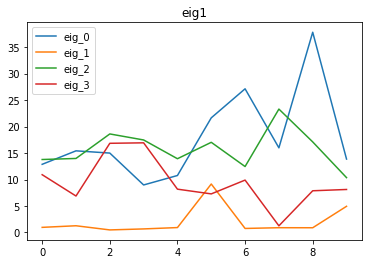

In [7]:

from skimage.measure import label,regionprops,perimeter
from skimage.morphology import binary_erosion,binary_opening
from scipy.fftpack import fft
per_0=[]
per_1=[]
per_2=[]
per_3=[]
surf_0=[]
surf_1=[]
surf_2=[]
surf_3=[]
mom_hue_0=[]
mom_hue_1=[]
mom_hue_2=[]
mom_hue_3=[]
eig_0=[]
eig_1=[]
eig_2=[]
eig_3=[]

for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
       im2=binary_opening(im>80,np.ones((2,2)))
       lab=label(im2)
       reg=regionprops(lab)
       per_0.append(perimeter(im2))
       mom_hue_0.append(reg[0].moments_hu)
       eig_0.append(reg[0].inertia_tensor_eigvals)
       surf_0.append(reg[0].area)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
       im2=binary_opening(im>80,np.ones((2,2)))
       lab=label(im2)
       reg=regionprops(lab)
       per_1.append(perimeter(im2))
       mom_hue_1.append(reg[0].moments_hu)
       eig_1.append(reg[0].inertia_tensor_eigvals)
       surf_1.append(reg[0].area)
for ax, im, nm in zip(axes[2], twos_im, twos_names):
       im2=binary_opening(im>80,np.ones((2,2)))
       lab=label(im2)
       reg=regionprops(lab)
       per_2.append(perimeter(im2))
       mom_hue_2.append(reg[0].moments_hu)
       eig_2.append(reg[0].inertia_tensor_eigvals)
       surf_2.append(reg[0].area)
for ax, im, nm in zip(axes[3], threes_im, threes_names):
       im2=binary_opening(im>80,np.ones((2,2)))
       lab=label(im2)
       reg=regionprops(lab)
       per_3.append(perimeter(im2))
       mom_hue_3.append(reg[0].moments_hu)
       eig_3.append(reg[0].inertia_tensor_eigvals)
       surf_3.append(reg[0].area)

# %% area perimeter
plt.figure()
plt.title('area')
plt.plot(surf_0,label='surf_0')
plt.plot(surf_1,label='surf_1')
plt.plot(surf_2,label='surf_2')
plt.plot(surf_3,label='surf_3')
plt.legend()

plt.figure()
plt.title('perimeter')
plt.plot(per_0,label='per_0')
plt.plot(per_1,label='per_1')
plt.plot(per_2,label='per_2')
plt.plot(per_3,label='per_3')
plt.legend()

plt.figure()
plt.title('area vs perimeter')
plt.scatter(surf_0,per_0,label='0')
plt.scatter(surf_1,per_1,label='1')
plt.scatter(surf_2,per_2,label='2')
plt.scatter(surf_3,per_3,label='3')
plt.legend()

#%% hue does not work well!
#plt.figure()
#plt.title('Moments hue')
#for i in range(np.shape(mom_hue_0)[0]):
#       plt.plot(mom_hue_0[i][0:4],'C0')
#       plt.plot(mom_hue_1[i][0:4],'C1')
#       #plt.plot(mom_hue_2[i][0:4],'C2')
#       #plt.plot(mom_hue_3[i][0:4],'C3')
#plt.legend()
#
#plt.figure()
#plt.title('area/ perimeter vs mom_hue')
#plt.scatter(np.divide(surf_0,per_0),[mom_hue_0[i][0] for i in range(np.shape(mom_hue_0)[0])],label='0')
#plt.scatter(np.divide(surf_1,per_1),[mom_hue_1[i][0] for i in range(np.shape(mom_hue_1)[0])],label='1')
#plt.scatter(np.divide(surf_2,per_2),[mom_hue_2[i][0] for i in range(np.shape(mom_hue_2)[0])],label='2')
#plt.scatter(np.divide(surf_3,per_3),[mom_hue_3[i][0] for i in range(np.shape(mom_hue_3)[0])],label='3')

# %% eigenvalues
plt.figure()
plt.title('eig0')
plt.plot([eig_0[i][0] for i in range(np.shape(eig_0)[0])],label='eig_0')
plt.plot([eig_1[i][0] for i in range(np.shape(eig_1)[0])],label='eig_1')
plt.plot([eig_2[i][0] for i in range(np.shape(eig_2)[0])],label='eig_2')
plt.plot([eig_3[i][0] for i in range(np.shape(eig_3)[0])],label='eig_3')
plt.legend()
plt.figure()
plt.title('eig1')
plt.plot([eig_0[i][1] for i in range(np.shape(eig_0)[0])],label='eig_0')
plt.plot([eig_1[i][1] for i in range(np.shape(eig_1)[0])],label='eig_1')
plt.plot([eig_2[i][1] for i in range(np.shape(eig_2)[0])],label='eig_2')
plt.plot([eig_3[i][1] for i in range(np.shape(eig_3)[0])],label='eig_3')
plt.legend();


It is noticed, that similarly to the Fourier descriptors, the differentiation between 2 and 3 is a problem. the best property where the values are separable (there is no intersections of the curves) would be the second eigenvalues of the inertia tensor. The differentiation between 0 and 1 doesn't pose any problems for any of the descriptors.

We try to improve the final result of the Fourier descriptors by plotting f0 vs f5 vs eig 1.


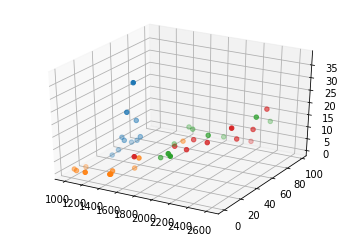

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([FT0[i][0] for i in range(FT0.size)],[FT0[i][5] for i in range(FT0.size)],[eig_0[i][1] for i in range(np.shape(eig_0)[0])])
ax.scatter([FT1[i][0] for i in range(FT1.size)],[FT1[i][5] for i in range(FT1.size)],[eig_1[i][1] for i in range(np.shape(eig_1)[0])])
ax.scatter([FT2[i][0] for i in range(FT2.size)],[FT2[i][5] for i in range(FT2.size)],[eig_2[i][1] for i in range(np.shape(eig_2)[0])])
ax.scatter([FT3[i][0] for i in range(FT3.size)],[FT3[i][5] for i in range(FT3.size)],[eig_3[i][1] for i in range(np.shape(eig_3)[0])])
plt.show()

This doesn't provide the desired result so lets try f0 vs surf vs eig1:

Zeros and ones scatter nicely together still and the separation between 2 and 3 can be slightly improved but the final result is not significantly better that the Fourier descriptor based approach.

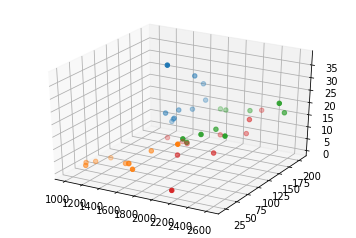

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([FT0[i][0] for i in range(FT0.size)],surf_0,[eig_0[i][1] for i in range(np.shape(eig_0)[0])])
ax.scatter([FT1[i][0] for i in range(FT1.size)],surf_1,[eig_1[i][1] for i in range(np.shape(eig_1)[0])])
ax.scatter([FT2[i][0] for i in range(FT2.size)],surf_2,[eig_2[i][1] for i in range(np.shape(eig_2)[0])])
ax.scatter([FT3[i][0] for i in range(FT3.size)],surf_3,[eig_3[i][1] for i in range(np.shape(eig_3)[0])])
plt.show()